In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
train_data_raw = pd.read_csv("./mnist_train/mnist_train.csv")

In [3]:
normalize_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_data = (train_data_raw.drop('5', axis=1)).to_numpy()
train_data = train_data.reshape(59999, 28, 28)
train_data = np.expand_dims(train_data, axis=1)
print(train_data.shape)

(59999, 1, 28, 28)


In [5]:
train_tensor_raw = torch.tensor(train_data, dtype=torch.float32)
print(train_tensor_raw.shape)

torch.Size([59999, 1, 28, 28])


In [6]:
train_tensor = normalize_transform(train_tensor_raw)

In [7]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

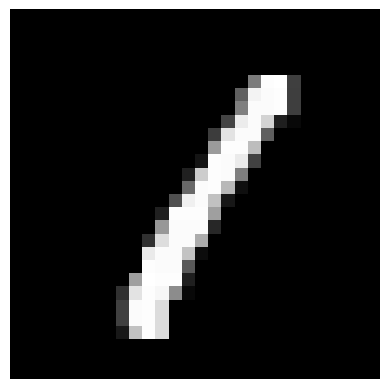

In [8]:
first_image = train_tensor[2][0].detach()
show_image(first_image)

In [9]:
in_channels = 64
feature_maps = 4
out_channels = 1
kernel_size = 4
stride_def = 2

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, feature_maps*4, kernel_size),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, kernel_size, stride=stride_def, padding=1),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps*2, out_channels, kernel_size, stride=stride_def, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)

In [11]:
generator = Generator()

# Figured out input dimension required to get target_dim sized output
target_dim = 28
gen_dim = target_dim
for layer in reversed([l for l in generator.net]):
    if hasattr(layer, 'kernel_size'):
        gen_dim = 1 + (gen_dim + 2*layer.padding[0] - layer.dilation[0]*(layer.kernel_size[0]-1) - layer.output_padding[0] - 1)/layer.stride[0]

print (gen_dim)
if gen_dim == 0:
    print ("NET TOO BIG! CANNOT MAKE SMALL ENOUGH IMAGE FROM EVEN SINGLE PIXEL INPUT TENSOR")
gen_dim = int(gen_dim)

4.0


In [12]:
image_batch = 10
input_tensor = torch.rand(image_batch, in_channels, gen_dim, gen_dim)

output_tensor = generator(input_tensor)
print(output_tensor.shape)
output_image = output_tensor[4][0].detach().numpy()
# show_image(output_image)

torch.Size([10, 1, 28, 28])


In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(out_channels, feature_maps, kernel_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps*2, kernel_size, stride=stride_def),
            nn.BatchNorm2d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps*2, feature_maps, kernel_size, stride=stride_def),
            nn.BatchNorm2d(feature_maps),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, 1, kernel_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [14]:
discriminator = Discriminator()
x = discriminator(output_tensor)
x.shape

torch.Size([10, 1, 1, 1])

In [15]:
lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

In [16]:
dataset = TensorDataset(train_tensor)

In [17]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 5

In [ ]:
for epoch in range(num_epochs):
    print("Entering Epoch " + str(epoch))
    for i, real_images in enumerate(dataloader):
        if i % 100 == 0:
            print ("Working %dth image", i)
        batch_size = real_images[0].size(0)

        real_labels = torch.ones(batch_size, 1, 1, 1)
        fake_labels = torch.zeros(batch_size, 1, 1, 1)

        real_outputs = discriminator(real_images[0])
        optimizer_D.zero_grad()
        
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, in_channels, gen_dim, gen_dim)
        fake_images = generator(z)      
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

Entering Epoch 0
Entering Epoch 1


In [ ]:
output_tensor2 = generator(input_tensor)
output_image2 = output_tensor2[3][0].detach().numpy()
show_image(output_image2)
print(output_image2.shape)

In [ ]:
input_tensor2 = torch.rand(image_batch, in_channels, gen_dimensions, gen_dimensions)

In [ ]:
output_tensor3 = generator(input_tensor2)
output_image3 = output_tensor3[3][0].detach().numpy()
show_image(output_image3)
print(output_image3.shape)